In [12]:
import os 
import torch
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize

def read_image(transform, path, unit):
    images = []
    labels = []
    # path = r'.\Data\seg_train'
    for num, picture_class in enumerate([os.path.join(path, file) for file in unit]):
        # print(num, picture_class)
        # num 等同于标签
        for file in os.listdir(picture_class):         # 返回列表
            image = os.path.join(picture_class, file)  # 返回完整图片路径
            images.append(transform(Image.open(image)))
            labels.append(num)
    return images, labels  

class image_dataset(Dataset):
    def __init__(self, path, unit) -> None:
        super().__init__()
        # 图片转换
        self.transform = Compose([
            Resize((128, 128)),
            ToTensor()
        ])
        self.read_image = read_image(transform=self.transform, path=path, unit=unit)
        self.images, self.labels = self.read_image

    def __len__(self,):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

if __name__ =='__main__':
    train_data = image_dataset(path = r'.\Data\seg_train', unit = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_data = image_dataset(path = r'.\Data\seg_test', unit = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
    test_loader = DataLoader(dataset=test_data, shuffle=True)

In [13]:
import dill
# 保存 训练数据 测试数据
with open(r'./Data/train_loader.pth', 'wb') as f:
    dill.dump(train_loader, f)

with open(r'./Data/test_loader.pth', 'wb') as f:
    dill.dump(test_loader, f)

In [34]:
torch.save(train_loader, r'./Data/train_loader.pth')
torch.save(test_loader, r'./Data/test_loader.pth')

In [2]:
import torch
Train_image = torch.load(r'./Data/train_loader.pth')

for image, label in Train_image:
    print(image.shape, type(image), label)

AttributeError: Can't get attribute 'image_dataset' on <module '__main__'>

JPEG (150, 150) RGB


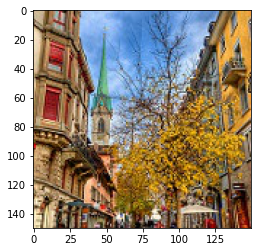

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

picture = Image.open(r'./Data/seg_pred/10004.jpg')
picture_2 = Image.open(r'./Data/seg_pred/10005.jpg')

print(picture.format, picture.size, picture.mode)
plt.imshow(picture)
plt.show()


In [2]:
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor
transform = Compose([
    Resize(size=(150, 150)),
    ToTensor(),
    ])
image = []
image.append(transform(picture).numpy())
image.append(transform(picture_2).numpy())
image = torch.tensor(image)
image.shape

C:\Users\1\AppData\Local\Temp\ipykernel_2588\2646116654.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  image = torch.tensor(image)


torch.Size([2, 3, 150, 150])

In [3]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# 图像补丁操作
rearrange_tensor = rearrange(image, 'b c (h p1) (w p2) -> b (h w) p1 p2 c', p1=50, p2=50)
rearrange_tensor_2 = rearrange(image, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=50, p2=50)

In [4]:
print(rearrange_tensor.shape, rearrange_tensor_2.shape)

torch.Size([2, 9, 50, 50, 3]) torch.Size([2, 9, 7500])


In [7]:
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange

class FeedForward(nn.Module):
    def __init__(self, dim, dropout) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        ) 
    def forward(self, x):
        x = self.net(x)
        return x 
        
class Attention(nn.Module):
    def __init__(self, dim) -> None:
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        emb = torch.matmul(F.softmax(torch.matmul(q, k.transpose(-1, -2))/math.sqrt(x.shape[-1]), dim=-1), v)
        
        return emb

class Multi_Head_Attention(nn.Module):
    def __init__(self, dim, n_head) -> None:
        super().__init__()
        assert dim % n_head == 0 
        self.n_head = n_head
        self.attention = Attention(dim=dim//self.n_head)

    def split(self, x):
        n_batch, num, length = x.shape
        x = x.view(n_batch, self.n_head, num, length//self.n_head).contiguous()
        return x 

    def concat(self, x):
        n_batch, n_head, num, length = x.shape
        x = x.view(n_batch, num, n_head*length).contiguous()
        return x 

    def forward(self, x):
        x = self.split(x)
        # print('---split---:', x.shape)
        x = self.attention(x)
        x = self.concat(x)
        # print('---concat--:', x.shape)
        return x 

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.beta
        return out
        

class Encoder_layer(nn.Module):
    def __init__(self, dim, n_head, dropout) -> None:
        super().__init__()
        self.norm = LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Multi_Head_Attention(dim, n_head)
        self.ffn = FeedForward(dim=dim, dropout=dropout)

    def forward(self, x):
        # 残差连接
        x_ = x
        x = self.attention(x)
        x = self.norm(x + x_)
        x = self.dropout(x)
        x_ = x
        x = self.ffn(x)
        x = self.norm(x + x_)
        x = self.dropout(x)
        return x 
        
class Encoder(nn.Module):
    def __init__(self, dim, n_head, dropout, n_layers) -> None:
        super().__init__()
        self.n_layers = nn.ModuleList([Encoder_layer(dim, n_head, dropout) for _ in range(n_layers)])

    def forward(self, x):
        for layers in self.n_layers:
            x = layers(x)
        return x 

class Mlp_Head(nn.Module):
    def __init__(self, hidden_dim, num_class, dropout) -> None:
        super().__init__()
        self.net = nn.Sequential(
            Rearrange('b n l -> b (n l)'),
            nn.Linear(hidden_dim, num_class), 
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x 



In [8]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class VIT(nn.Module):
    def __init__(self, image_height, image_width, in_channels, patch_height, patch_width, dim, n_head, p, n_layers, num_class) -> None:
        super().__init__()
        
        # 整除操作
        assert image_height % patch_height == 0 and image_width % patch_width == 0 
        patch_dim = patch_height * patch_width * in_channels
        num_patches = (image_height * image_width)//(patch_height*patch_width)

        # 切割图片，并扁平化处理
        self.patches_embedding = nn.Sequential(
            Rearrange(pattern='b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width), 
            nn.Linear(patch_dim, dim)
        )
        # 位置编码
        self.pos_embedding = nn.Parameter(torch.randn(size=(1, int(num_patches)+1, dim)))
        # 类别信息
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, dim)))
        self.dropout = nn.Dropout(p)
        # 编码器
        self.encoder = Encoder(dim, n_head, p, n_layers)
        # 投影
        self.mlp = Mlp_Head(hidden_dim=dim*(1+num_patches), num_class=num_class, dropout=p)

    def forward(self, x):
        x = self.patches_embedding(x)
        # print('X:', x.shape)
        batch, n, _ = x.shape
        # 拼接class_token信息
        cls_token = repeat(self.cls_token, '1 1 d -> b 1 d', b=batch)
        # print('class token:', cls_token.shape)
        x = torch.cat((cls_token, x), dim=1)
        # batch里每个图片均加入相同的位置编码信息
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        # Transformer 编码器
        x = self.encoder(x)
        x = self.mlp(x)       
        # print('X:', x.shape)        
        return x 


Epoch: 0 Model Loss: 1.4831708127802068 Accuracy:  0.4131395183126692
Epoch: 1 Model Loss: 1.3160368659279562 Accuracy:  0.49287444776970213
Epoch: 2 Model Loss: 1.23685350634835 Accuracy:  0.5262220322074961
Epoch: 3 Model Loss: 1.1849319577217101 Accuracy:  0.546102322930027
Epoch: 4 Model Loss: 1.1474795498631216 Accuracy:  0.5602109163460168
Epoch: 5 Model Loss: 1.1181879436427897 Accuracy:  0.5773834972210347
Epoch: 6 Model Loss: 1.0820002750916915 Accuracy:  0.5918483682485393
Epoch: 7 Model Loss: 1.0647688705812801 Accuracy:  0.5915633461593274
Epoch: 8 Model Loss: 1.0159514386545527 Accuracy:  0.6164315234430668
Epoch: 9 Model Loss: 1.0069057529622858 Accuracy:  0.6226307538834259
Epoch: 10 Model Loss: 0.9871628921140324 Accuracy:  0.6265498076100898
Epoch: 11 Model Loss: 0.9706648376854983 Accuracy:  0.6269060852216046
Epoch: 12 Model Loss: 0.9502603579651225 Accuracy:  0.6366680917771127
Epoch: 13 Model Loss: 0.9381824664094232 Accuracy:  0.6446487102750463
Epoch: 14 Model Lo

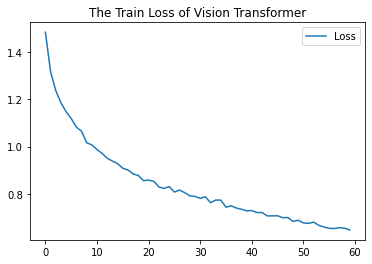

In [9]:
import dill
import numpy as np 
import torch
import torch.nn.functional as F
import torch.optim as optim 
from sklearn.metrics import accuracy_score

def train(network, learning_rate, epoches, path, device):
    # 定义交叉熵损失函数和优化器
    Loss = []
    loss_func = nn.CrossEntropyLoss()
    model_optim = optim.AdamW(network.parameters(), lr=learning_rate)
    # 数据导入
    with open(r'./Data/train_loader.pth', 'rb') as f:
        train_image = dill.load(f)
        # 模型训练
        for epoch in range(epoches):
            train_loss = []
            predict = []
            image_label = []
            for image, label in train_image:
                output = network(image.to(device))
                model_loss = loss_func(output, label.to(device))
                # 参数优化
                model_optim.zero_grad()
                model_loss.backward()
                # 计算梯度
                model_optim.step()
                # 损失
                train_loss.append(model_loss.detach().cpu().item())
                # 网络预测
                predict.extend(output.argmax(dim=1).detach().cpu().tolist())
                image_label.extend(label.detach().cpu().tolist())

            assert len(predict) == len(image_label)
            acc = accuracy_score(image_label, predict)
            # 每个Epoch损失平均值
            Loss.append(np.mean(np.array(train_loss)))
            print('Epoch:', epoch, 'Model Loss:', Loss[-1], 'Accuracy: ', acc)

    # 模型保存
    torch.save(network.state_dict(), path, _use_new_zipfile_serialization=False)

    import matplotlib.pyplot as plt
    plt.title('The Train Loss of Vision Transformer')
    plt.plot(range(len(Loss)), Loss, label='Loss')
    plt.legend()
    plt.show()



if __name__ =='__main__':
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    vision_transformer = VIT(image_height=128, image_width=128, in_channels=3, patch_height=16, patch_width=16, dim=64, n_head=8, p=0.1, n_layers=5, num_class=6).to(device)
    train(network=vision_transformer, learning_rate=0.0005, epoches=60, path=r'./Model/vit.pth', device=device)

In [10]:
vit = VIT(image_height=128, image_width=128, in_channels=3, patch_height=16, patch_width=16, dim=64, n_head=8, p=0.1, n_layers=5, num_class=6)
vit.load_state_dict(torch.load(r'./Model/vit.pth'))

<All keys matched successfully>

In [11]:
from sklearn.metrics import accuracy_score

def test(path):
    predict = []
    label = []
    # 导入测试数据
    with open(r'./Data/test_loader.pth', 'rb') as f: 
        test_image = dill.load(f)
        for image_item, label_item in test_image:
            output = vit(image_item)
            predict.append(output.argmax(dim=1).detach().cpu().item())
            label.append(label_item.item())
        
    print('测试数据：', len(label))
    print('Accuracy:', accuracy_score(label, predict))


if __name__  == '__main__':
    test(path=r'./Data/test_loader.pth')

测试数据： 3000
Accuracy: 0.7063333333333334
